In [7]:
import pandas as pd
import numpy as np
import pickle
import os
import glob
import argparse  # Import argparse for command-line arguments

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For color normalization

from pathlib import Path
# import spikedata
# from spikedata.spikedata import SpikeData
from braindance.analysis.mapping import Mapping # Moved import higher

# Data Explanation

### 1. Define Path Pickled Dataset

In [8]:
dataset_dir = Path(os.path.join("project_data"))

# --- File Paths ---
metadata_path = dataset_dir / 'metadata.pkl'
baseline_sd_path = dataset_dir / 'baseline_spike_data.pkl'
adaptive_sd_path = dataset_dir / 'exp1_cartpole_long_6_spike_data.pkl'
random_sd_path = dataset_dir / 'exp1_cartpole_long_7_spike_data.pkl'
none_sd_path = dataset_dir / 'exp1_cartpole_long_8_spike_data.pkl'
adaptive_logs_path = dataset_dir / 'exp1_cartpole_long_6_logs.pkl'
random_logs_path = dataset_dir / 'exp1_cartpole_long_7_logs.pkl'
none_logs_path = dataset_dir / 'exp1_cartpole_long_8_logs.pkl'

### 2. Load the Pickled Data

In [9]:
# --- Helper Functions ---
def load_pickle(p):
    with open(p, 'rb') as f:
        data = pickle.load(f)
    return data

In [10]:
# --- Data Loading ---
print("Loading experiment data...", end='\t')
metadata = load_pickle(metadata_path)
baseline_sd = load_pickle(baseline_sd_path)
adaptive_sd = load_pickle(adaptive_sd_path)
adaptive_logs = load_pickle(adaptive_logs_path) # Logs might be needed later
random_sd = load_pickle(random_sd_path)
random_logs = load_pickle(random_logs_path)
none_sd = load_pickle(none_sd_path)
none_logs = load_pickle(none_logs_path)
print("Complete!")

Loading experiment data...	Complete!


### 3. Further Data Extraction

In [11]:
# --- Data Extraction ---
mapping = metadata['mapping']
encode_electrodes = metadata['encode_electrodes']
decode_electrodes = metadata['decode_electrodes']
training_electrodes = metadata['training_electrodes']
spike_channels = metadata['spike_channels'] # List of arrays
spike_locs = metadata['spike_locs'] # List of tuples/arrays (x, y)

# Ensure spike_locs is a numpy array for easier slicing
spike_locs = np.array(spike_locs)
spikes_x = spike_locs[:, 0]
spikes_y = spike_locs[:, 1]

# --- Mapping and Positions ---
mapper = Mapping().from_df(mapping)
encode_positions = mapper.get_positions(electrodes=encode_electrodes)
decode_positions = mapper.get_positions(electrodes=decode_electrodes)
training_positions = mapper.get_positions(electrodes=training_electrodes)
all_positions = mapper.get_positions()

## Metadata explained

The metadata is a dict with the following keys: 
* `'mapping'`: mapping                        $\implies$ pd dataframe mapping of the channels/electrodes to positions
* `'fs'`: fs                                  $\implies$ The sampling frequency
* `'stim_electrodes'`: stim_electrodes        $\implies$ The electrodes that were stimulated
* `'stim_inds'`: stim_inds                    $\implies$ The indices of the stimulated electrodes
* `'encode_electrodes'`: encode_electrodes    $\implies$ The electrodes that were used to stimulate in information
* `'encode_inds'`: encode_inds                $\implies$ The corresponding indices of the encode electrodes
* `'decode_electrodes'`: decode_electrodes    $\implies$ The electrodes that were used to decode information
* `'training_electrodes'`: training_electrodes $\implies$ The electrodes that were used to train the model
* `'training_inds'`: training_inds            $\implies$ The corresponding indices of the training electrodes
* `'spike_channels'`: spike_channels          $\implies$ List of arrays of channels for each sorted neuron
* `'spike_locs'`: spike_locs                  $\implies$ x,y position of each sorted neuron

In [13]:
print(type(metadata))
print(metadata.keys())

<class 'dict'>
dict_keys(['mapping', 'fs', 'stim_electrodes', 'stim_inds', 'encode_electrodes', 'encode_inds', 'decode_electrodes', 'training_electrodes', 'training_inds', 'spike_channels', 'spike_locs'])


The metadata has lots of important information, for example it has the location of the spikesorted electrodes

In [31]:
metadata['mapping'].head(5)

,channel,electrode,x,y
0,0,18598,2065.0,1470.0
1,1,20644,3220.0,1627.5
2,2,19040,2100.0,1505.0
3,3,21723,2852.5,1715.0
4,4,14939,3482.5,1172.5


The sampling frequency

In [34]:
print(metadata['fs'])

20000


Which electrodes are **stim**, **training**, **encoding**, and **decoding**

In [35]:
print(metadata['stim_electrodes'])
print(metadata['encode_electrodes'])
print(metadata['decode_electrodes'])
print(metadata['training_electrodes'])

[23275, 24768, 22182, 23923, 909, 3229, 17335, 25039]
[23275, 25039]
[18429, 18385]
[24768, 22182, 23923, 909, 3229, 17335]


The data for spike raster and spike locations

In [43]:
# print first 10
print(metadata['spike_locs'][0:10])
# print length
print(len(metadata['spike_locs']))

[[2065.  1470. ]
 [2065.  1470. ]
 [2100.  1505. ]
 [3185.  1662.5]
 [3185.  1662.5]
 [3185.  1662.5]
 [3150.  1557.5]
 [3150.  1575. ]
 [3150.  1575. ]
 [3150.  1785. ]]
108


## Spiking Data Explained

The spiking data (sd) the following: 
* `baseline_sd`          $\implies$ The SpikeData object for the baseline recording
* `adaptive_sd`          $\implies$ The SpikeData object for the adaptive recording
* `random_sd`            $\implies$ The SpikeData object for the random recording
* `none_sd`              $\implies$ The SpikeData object for the none recording

For more info about the SpikeData class: https://github.com/braingeneers/SpikeData

In [16]:
print(type(baseline_sd))
print(type(adaptive_sd))
print(type(random_sd))
print(type(none_sd))

<class 'spikedata.spikedata.SpikeData'>
<class 'spikedata.spikedata.SpikeData'>
<class 'spikedata.spikedata.SpikeData'>
<class 'spikedata.spikedata.SpikeData'>


We learned in a previous electrophysiology homework we can easily plot the STTC from this class

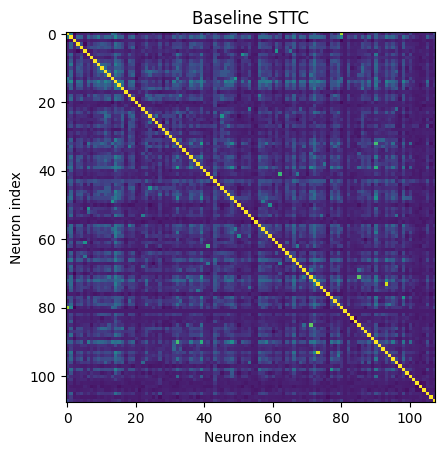

In [29]:
sttc = baseline_sd.spike_time_tilings()
plt.title('Baseline STTC')
plt.imshow(sttc)
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

## Logs:

* ( Baseline has no logs )
* Logs has the keys ['game', 'reward', 'log', 'pattern']
* Each of the values from these keys is a pandas dataframe with the following columns:

Logs is a dict with the keys:
* `'game'`: `['time','pole_angle', 'reward', 'action', 'x', 'xdot', 'theta', 'thetadot']` # This is the game log
* `'reward'`: `['time', 'episode','reward']` # This is the reward log
* `'log'`: `['time', 'amplitude', 'duty_time_ms', 'stim_electrodes', 'tag', 'stim_pattern']` # This is the stim log
* `'pattern'`: `['pattern', 'time', 'stim_indices']` # This is the training stimulus log

In [17]:
print(type(adaptive_logs))

<class 'dict'>


This is the log of the cartpole game state over time

In [21]:
adaptive_logs['game'].head(5)

,time,pole_angle,action,x,xdot,theta,thetadot
0,0.214106,-0.020200,1.0000,-0.040879,0.187582,-0.020200,-0.300026
1,0.416450,-0.026201,1.0000,-0.037127,0.382986,-0.026201,-0.599010
2,0.620427,-0.038181,1.0000,-0.029468,0.578465,-0.038181,-0.899830
3,0.822734,-0.056178,-0.8832,-0.017898,0.406668,-0.056178,-0.653545
4,1.025152,-0.069249,1.0000,-0.009765,0.602526,-0.069249,-0.963375


This is the log of the reward over time

In [22]:
adaptive_logs['reward'].head(5)

,time,episode,reward
0,3.911218,0,19.0
1,18.770805,1,56.0
2,24.654084,2,12.0
3,31.596691,3,17.0
4,38.112137,4,15.0


In a previous homework we learned to plot the rewards over time

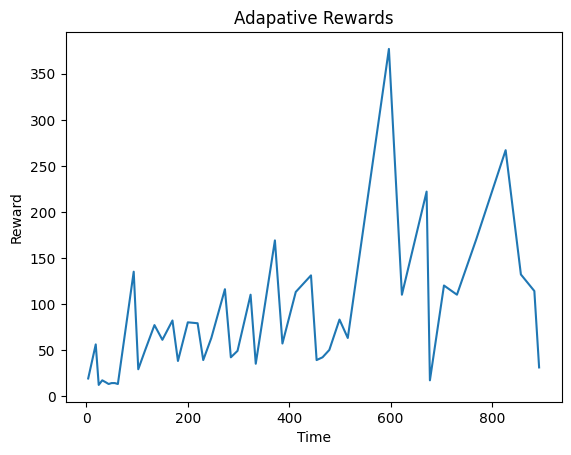

In [30]:
plt.plot(adaptive_logs['reward']['time'], adaptive_logs['reward']['reward'])
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Adapative Rewards')
plt.show()

This is the log of the stimulus over time

In [23]:
adaptive_logs['log'].head(5)

,time,amplitude,duty_time_ms,stim_electrodes,tag,stim_pattern
0,0.96075,400,200,"[23275, 25039]",sensory,"(23275, 25039)"
1,1.53725,400,200,[23275],sensory,"(23275,)"
2,1.96070,400,200,[23275],sensory,"(23275,)"
3,2.28165,400,200,[23275],sensory,"(23275,)"
4,2.56130,400,200,[23275],sensory,"(23275,)"


This is the log of the reward to which stimulus indices over time

In [24]:
adaptive_logs['pattern'].head(5)

,time,reward,stim_indices
0,3.911506,19.0,"[4, 3]"
1,4.019525,19.0,"[4, 3]"
2,4.128859,19.0,"[4, 3]"
3,4.237211,19.0,"[4, 3]"
4,18.771035,56.0,"[6, 5]"
